# Mt. Rainier Climbing Analysis

### Predicting success rate of summit attempts using weather and route data

#### Introduction

Attempting to climb a mouintain is no easy feat and the task itself requires months of training and preparation especially when it comes to climbing a mountain like Mt. Rainier that has snow year round. The reward of making it to the top is blessed with amazing views in all directions, but also a sense of accomplishment that can't be explained by more than the completetion of a task that took months to prepare for mentally and physically. 

While the weather in the Pacific Northwest is normally pretty nice in the summers, once you get to higher elevations you can throw that out the window. The weather becomes unpredictable above the alpine line where mountains have there own micro-climate, especially Mt. Rainier. To complete months of training to only have it ruined by the weather would be devastating for most as Mt. Rainier is the crown jewel of mountains in the cascade range and it might take a couple years to get another chance to summit. In this report we will find the most successful time to climb Mt. Rainier so that you can schedule accordly to have the weather be one less factor in the way of completing this awesome feat. 

#### Data Source 

We will be using data gathered from the 2014 and 2015 climbing seasons that was provided by the National Park Service. 

### Methodology
First we will comb through the dataset to find any interesting or relevant connections that might prove useful when building our model. Then we will combine our datasets and fix any discrepancies that might occur from mismatching dates or likewise. This will set us up to look for any interesting connections that might be relevant when combining the datasets. Once we finish this we will set up our model. Logistic regression and Random Forest are the first two supervised learning models that come to mind. Unsupervised modeling methods seem excessive and not necessary considering the size of the dataset. Lastly we will try an ensemble technique using bagging and boosting which will combine our models to give us a more clear line of what determines a successful climb when looking at just the weather and route data. 

Now let's take a brief look at our data to see what we are looking at and if there is any missing data. 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load data
weather = pd.read_csv("Rainier_Weather.csv")
climbing_stats = pd.read_csv("climbing_statistics.csv")

#### Print Visual of our Data

In [4]:
print(weather)

           Date  Battery Voltage AVG  Temperature AVG  Relative Humidity AVG  \
0    12/31/2015            13.845000        19.062917              21.870833   
1    12/30/2015            13.822917        14.631208              18.493833   
2    12/29/2015            13.834583         6.614292              34.072917   
3    12/28/2015            13.710417         8.687042              70.557917   
4    12/27/2015            13.362500        14.140417              95.754167   
5    12/26/2015            13.531667        17.512917              47.574583   
6    12/25/2015            13.837083         3.215042              33.722500   
7    12/24/2015            13.681667         2.815375              76.065833   
8    12/23/2015            13.371667         2.005458              90.891667   
9    12/22/2015            13.681250         4.028125              91.316667   
10   12/21/2015            13.252500         8.244375              93.583333   
11   12/20/2015            13.568750    

In [5]:
print(climbing_stats)

            Date                   Route  Attempted  Succeeded  \
0     11/27/2015  Disappointment Cleaver          2          0   
1     11/21/2015  Disappointment Cleaver          3          0   
2     10/15/2015  Disappointment Cleaver          2          0   
3     10/13/2015           Little Tahoma          8          0   
4      10/9/2015  Disappointment Cleaver          2          0   
5      10/3/2015  Disappointment Cleaver         10          0   
6      10/3/2015  Disappointment Cleaver          2          0   
7      10/2/2015           Kautz Glacier          2          0   
8      10/2/2015  Disappointment Cleaver          2          0   
9      9/30/2015  Disappointment Cleaver          2          0   
10     9/28/2015  Disappointment Cleaver         12          4   
11     9/27/2015  Disappointment Cleaver         12          6   
12     9/26/2015  Disappointment Cleaver          2          0   
13     9/26/2015  Disappointment Cleaver         12          3   
14     9/2

In [6]:
# check if we have any missing data
weather.isnull().values.any()

False

In [7]:
climbing_stats.isnull().values.any()

False

In [8]:
print(len(weather))

464


In [9]:
print(len(climbing_stats))

4077


### Exploratory Questions

    1. Which route is used the most?

    2. Which route has the highest success rate?

##### Which Route is used the most?

In [10]:
weather['Date'] = pd.to_datetime(weather['Date'].str.strip(), format='%m/%d/%Y')

In [11]:
climbing_stats['Date'] = pd.to_datetime(climbing_stats['Date'].str.strip(), format='%m/%d/%Y')

In [12]:
# check what datatypes we are working with for our weather data
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464 entries, 0 to 463
Data columns (total 7 columns):
Date                     464 non-null datetime64[ns]
Battery Voltage AVG      464 non-null float64
Temperature AVG          464 non-null float64
Relative Humidity AVG    464 non-null float64
Wind Speed Daily AVG     464 non-null float64
Wind Direction AVG       464 non-null float64
Solare Radiation AVG     464 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 25.5 KB


In [13]:
# check what datatypes we are working with in our climbing data
climbing_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4077 entries, 0 to 4076
Data columns (total 5 columns):
Date                  4077 non-null datetime64[ns]
Route                 4077 non-null object
Attempted             4077 non-null int64
Succeeded             4077 non-null int64
Success Percentage    4077 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 159.3+ KB


In [14]:
#combined_set = pd.DataFrame(columns=['Date','Battery Voltage AVG','Temperature AVG','Relative Humidity AVG','Wind Speed Daily AVG','Wind Direction AVG','Solar Radiation AVG','Route','Attempted','Succeeded','Success Ratio']) 
# we need to convert our data to string data before we can combine it or else we will get an error
#for index,row in climbing_stats.iterrows():
#   weather_rows=weather.loc[weather['Date'] == row['Date']]
#    combined_set = combined_set.append({'Date':row['Date'],'Battery Voltage AVG':weather['Battery Voltage AVG'].to_string(index=False,header=False),
#                  'Temperature AVG':weather['Temperature AVG'].to_string(index=False,header=False),
#                  'Relative Humidity AVG':weather['Relative Humidity AVG'].to_string(index=False,header=False),
#                  'Wind Speed Daily AVG':weather['Wind Speed Daily AVG'].to_string(index=False,header=False),
#                  'Wind Direction AVG':weather['Wind Direction AVG'].to_string(index=False,header=False),
#                  'Solar Radiation AVG':weather['Solare Radiation AVG'].to_string(index=False,header=False),
#                  'Route':row['Route'],'Attempted':row['Attempted'],'Succeeded':row['Succeeded'],
#                  'Success Ratio':row['Success Percentage']}, ignore_index=True)


In [15]:
# well that didn't work we ended up having /n for spaces and multiple datapoints for each variable on a single date
# let's try pd.merge from the pandas docs
combined_set = climbing_stats.merge(weather, on="Date")
combined_set.head(10)

,Date,Route,Attempted,Succeeded,Success Percentage,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
0,2015-11-27,Disappointment Cleaver,2,0,0.0,13.643750,26.321667,19.715000,27.839583,68.004167,88.496250
1,2015-11-21,Disappointment Cleaver,3,0,0.0,13.749583,31.300000,21.690708,2.245833,117.549667,93.660417
2,2015-10-15,Disappointment Cleaver,2,0,0.0,13.461250,46.447917,27.211250,17.163625,259.121375,138.387000
3,2015-10-13,Little Tahoma,8,0,0.0,13.532083,40.979583,28.335708,19.591167,279.779167,176.382667
4,2015-10-09,Disappointment Cleaver,2,0,0.0,13.216250,38.260417,74.329167,65.138333,264.687500,27.791292
5,2015-10-03,Disappointment Cleaver,10,0,0.0,13.577500,31.822917,62.337083,13.125042,153.931667,196.375208
6,2015-10-03,Disappointment Cleaver,2,0,0.0,13.577500,31.822917,62.337083,13.125042,153.931667,196.375208
7,2015-10-02,Kautz Glacier,2,0,0.0,13.505000,36.064167,47.017375,6.445917,247.318333,176.265542
8,2015-10-02,Disappointment Cleaver,2,0,0.0,13.505000,36.064167,47.017375,6.445917,247.318333,176.265542
9,2015-09-30,Disappointment Cleaver,2,0,0.0,13.483333,38.729583,57.369583,11.300750,216.934167,202.812750


In [16]:
# reset our index because I'm pretty sure our values are not aligned and out of order.
combined_set.sort_values('Date', inplace=True)
combined_set.reset_index(drop=True, inplace=True)
combined_set.head(10)

,Date,Route,Attempted,Succeeded,Success Percentage,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
0,2014-09-23,Disappointment Cleaver,11,0,0.000000,13.056667,32.857333,100.000000,65.110667,254.273333,16.593800
1,2014-09-24,Disappointment Cleaver,12,0,0.000000,13.168750,29.702917,100.000000,45.915000,278.054167,37.873708
2,2014-09-25,Disappointment Cleaver,2,2,1.000000,13.648333,26.823750,99.854167,3.166208,278.604167,142.698917
3,2014-09-25,Disappointment Cleaver,12,6,0.500000,13.648333,26.823750,99.854167,3.166208,278.604167,142.698917
4,2014-09-26,Disappointment Cleaver,5,0,0.000000,13.532500,28.238333,100.000000,0.897625,259.645833,114.400833
5,2014-09-26,Disappointment Cleaver,12,7,0.583333,13.532500,28.238333,100.000000,0.897625,259.645833,114.400833
6,2014-09-26,Disappointment Cleaver,3,3,1.000000,13.532500,28.238333,100.000000,0.897625,259.645833,114.400833
7,2014-09-26,Disappointment Cleaver,2,0,0.000000,13.532500,28.238333,100.000000,0.897625,259.645833,114.400833
8,2014-09-26,Disappointment Cleaver,3,0,0.000000,13.532500,28.238333,100.000000,0.897625,259.645833,114.400833
9,2014-09-26,Disappointment Cleaver,8,6,0.750000,13.532500,28.238333,100.000000,0.897625,259.645833,114.400833


In [17]:
combined_set['Route'].value_counts()

Disappointment Cleaver              1294
Emmons-Winthrop                      295
Kautz Glacier                         97
Little Tahoma                         36
Gibralter Ledges                      29
Liberty RIngraham Directge            29
Fuhrers Finger                        27
glacier only - no summit attempt      25
Ingraham Direct                       24
Ptarmigan RIngraham Directge           8
Kautz Cleaver                          7
Fuhrer's Finger                        5
Tahoma Glacier                         4
Mowich Face                            3
Wilson Headwall                        2
Curtis RIngraham Directge              2
Success Cleaver                        2
Nisqually Glacier                      2
Unknown                                1
Gibralter Chute                        1
Sunset RIngraham Directge              1
Tahoma Cleaver                         1
Name: Route, dtype: int64

In [18]:
# looks good right? We'll if you look closely there is a route named Fuhrers Finger and 
# another route named Fuhrer's Finger. Afer looking into this they are actually
# the same route and we need to combine the two routes. So let's do that now.
combined_set.Route.replace("Fuhrer's Finger", "Fuhrers Finger", inplace=True)

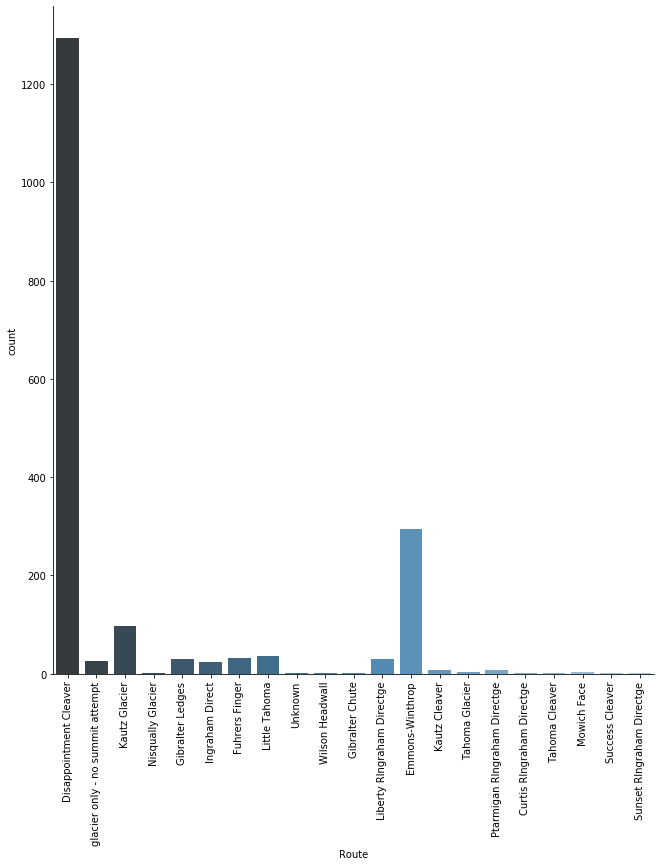

In [19]:
g = sns.catplot(x= 'Route', data = combined_set, kind = 'count', palette = 'Blues_d', height=(10))
g.set_xticklabels(rotation=90)

###### Result
Looking at our bar graph we can see that by far the most popular route is the Disappointment Cleaver route. A couple other routes had quite a few attempts but not even close to Disappointment Cleaver. 

#### Which route has the highest success rate?

In [20]:
# we'll need the route names and the success and attempts columns for this one
climbingsuccessbyRoute = combined_set.groupby(['Route'])["Attempted", "Succeeded"].sum().reset_index()

In [21]:
# make sure we are getting what we want
climbingsuccessbyRoute.head()

,Route,Attempted,Succeeded
0,Curtis RIngraham Directge,4,2
1,Disappointment Cleaver,7508,3740
2,Emmons-Winthrop,1465,791
3,Fuhrers Finger,90,13
4,Gibralter Chute,3,0


In [22]:
# create new column called success percentage to see which route is the most successful
climbingsuccessbyRoute['Success Percentage'] = (climbingsuccessbyRoute['Succeeded']/climbingsuccessbyRoute['Attempted'])*100

In [23]:
climbingsuccessbyRoute.head()

,Route,Attempted,Succeeded,Success Percentage
0,Curtis RIngraham Directge,4,2,50.000000
1,Disappointment Cleaver,7508,3740,49.813532
2,Emmons-Winthrop,1465,791,53.993174
3,Fuhrers Finger,90,13,14.444444
4,Gibralter Chute,3,0,0.000000


In [24]:
climbingsuccessbyRoute.sort_values(['Success Percentage'], ascending=False)

,Route,Attempted,Succeeded,Success Percentage
16,Tahoma Cleaver,3,3,100.000000
2,Emmons-Winthrop,1465,791,53.993174
8,Kautz Glacier,523,267,51.051625
0,Curtis RIngraham Directge,4,2,50.000000
1,Disappointment Cleaver,7508,3740,49.813532
13,Ptarmigan RIngraham Directge,19,9,47.368421
9,Liberty RIngraham Directge,73,32,43.835616
10,Little Tahoma,147,56,38.095238
17,Tahoma Glacier,11,4,36.363636
7,Kautz Cleaver,17,6,35.294118


[Text(0, 0, 'Curtis RIngraham Directge'),
 Text(0, 0, 'Disappointment Cleaver'),
 Text(0, 0, 'Emmons-Winthrop'),
 Text(0, 0, 'Fuhrers Finger'),
 Text(0, 0, 'Gibralter Chute'),
 Text(0, 0, 'Gibralter Ledges'),
 Text(0, 0, 'Ingraham Direct'),
 Text(0, 0, 'Kautz Cleaver'),
 Text(0, 0, 'Kautz Glacier'),
 Text(0, 0, 'Liberty RIngraham Directge'),
 Text(0, 0, 'Little Tahoma'),
 Text(0, 0, 'Mowich Face'),
 Text(0, 0, 'Nisqually Glacier'),
 Text(0, 0, 'Ptarmigan RIngraham Directge'),
 Text(0, 0, 'Success Cleaver'),
 Text(0, 0, 'Sunset RIngraham Directge'),
 Text(0, 0, 'Tahoma Cleaver'),
 Text(0, 0, 'Tahoma Glacier'),
 Text(0, 0, 'Unknown'),
 Text(0, 0, 'Wilson Headwall'),
 Text(0, 0, 'glacier only - no summit attempt')]

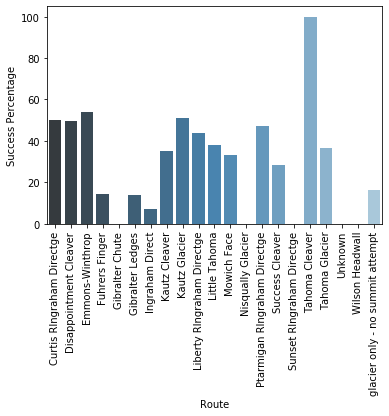

In [25]:
ax = sns.barplot(x= 'Route', y = 'Success Percentage', data = climbingsuccessbyRoute, palette = 'Blues_d')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

###### Result
Looking at the graph we can see that the route with highest completion percentage is the Tahoma Cleaver route. The only downside for this is that is only has 3 attempts. If we look at other routes we can see that they are mostly clustered around 50% with the Emmons-Winthrop route coming in at 54%. I would recommend this route because it has the highest success rate as we will see it also has an advantage over the other routes that can be used to achieve a higher chance of summiting Mt. Rainier.  

### Predicting Future Success

Now we will try to take what we have learned and build a model to predict future success of climbers. For this we will use Logistic Regression as we are trying to find whether the climb was successful or not, being there is only two possible outcomes. The variables we will use for this are which route was used, wind direction split into 8 different directions, and lastly we will consider the wind speed at certain thresholds. After we get our base model setup we will reiterate and do some tuning to see if we can improve it, possibly by adding features. After that we will try and use a different machine learning technique called Random Forest which is good for predicting categorical outcomes and uses Shannon Entropy which seems logical in determining a successful climb. We will include temperature and solar radiation in our base model and then tune our model to see if we are missing any features. 

In [66]:
def degToCompass(num):
    val=int((num/45)+.5)
    arr=["N","NE","E","SE","S","SW","W","NW"]
    return arr

SyntaxError: invalid syntax (<ipython-input-66-c8c6db473288>, line 2)

In [64]:
combined_set['Wind Direction AVG'] = combined_set['Wind Direction AVG'].apply(degToCompass)

In [65]:
combined_set.head()

,Date,Route,Attempted,Succeeded,Success Percentage,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
0,2014-09-23,Disappointment Cleaver,11,0,0.0,13.056667,32.857333,100.000000,65.110667,"[N, NE, E, SE, S, SW, W, NW]",16.593800
1,2014-09-24,Disappointment Cleaver,12,0,0.0,13.168750,29.702917,100.000000,45.915000,"[N, NE, E, SE, S, SW, W, NW]",37.873708
2,2014-09-25,Disappointment Cleaver,2,2,1.0,13.648333,26.823750,99.854167,3.166208,"[N, NE, E, SE, S, SW, W, NW]",142.698917
3,2014-09-25,Disappointment Cleaver,12,6,0.5,13.648333,26.823750,99.854167,3.166208,"[N, NE, E, SE, S, SW, W, NW]",142.698917
4,2014-09-26,Disappointment Cleaver,5,0,0.0,13.532500,28.238333,100.000000,0.897625,"[N, NE, E, SE, S, SW, W, NW]",114.400833
